Testing changes to haltere inspired weights.

In [49]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
import pickle
from estimator import classical_weights

In [2]:
def haltere_covariance_matrix(N, lowcut, highcut, decay_coef, scale=1):
    '''
    Generates the (N x N) covariance matrix for Gaussain Process inspired by the STAs 
    of mechanosensory neurons in insect halteres.
    
    $$k(t, t') = \mathbb{E}[w(t)^T w(t')] =  \sum_{j=0}^{N-1} \lambda_j \cos{\dfrac{i 2 \pi j (t-t')}{N}} * exp((- \|t- N - 1\|^2 + \|t'- N - 1\|^2) / a ** 2) $$
    $$ \lambda_j = \begin{cases} 1 & lowcut \leq highcut \\ 0 & otherwise \end{cases}$$

    Parameters
    ----------

    N: int
        Number of features
    
    lowcut: int
        low end of the frequency band filter

    highcut : int
        high end of the frequency band filter
        
    decay_coef : float
        controls the how fast the random features decay
    
    Returns
    -------
    C : array-like of shape (N, N) 
        Covariance matrix
    '''
    
    lamda = np.zeros(N)
    lamda[lowcut:highcut] = 1

    grid = np.arange(0, N)
    yy, xx = np.meshgrid(grid, grid)
    diff = xx - yy

    # sinusoidal part
    C_cos = np.zeros((N, N))
    for j in range(N):
        C_cos += lamda[j] * np.cos(2 * np.pi * j * diff / N)

    # exponential part
    C_exp = np.exp((-(xx - N) ** 2 - (yy - N) ** 2) / decay_coef ** 2)

    # final covariance matrix
    C = C_cos * C_exp 
    C *= (scale * N / np.trace(C))
    C += 1e-5 * np.eye(N)
    return C

def haltere_inspired_weights(M, N, lowcut, highcut, decay_coef, scale=1, random_state=None):
    """
    Generates random weights with tuning similar to mechanosensory 
    neurons in insect halteres. Weights are band-limited gaussian 
    process with fourier eigenbasis.

    Parameters
    ----------

    M : int
        Number of random weights

    N : int
        Number of features

    lowcut: int
        Low end of the frequency band. 

    highcut: int
        High end of the frequency band.
        
    decay_coef : float
        controls the how fast the random features decay
    
    random_state : int, default=None
        Used to set the seed when generating random weights.
    
    Returns
    -------

    W : array-like of shape (M, N)
        Random weights.
    """
    np.random.seed(random_state)
    C = haltere_covariance_matrix(N, lowcut, highcut, decay_coef, scale)
    L = la.cholesky(C)
    W = np.dot(L, np.random.randn(N, M)).T
    return W

## plotting all covariance matrices

In [106]:
N, lowcut, highcut, decay_coef, scale = 1600, 3, 8, 500, 1

In [107]:
lamda = np.zeros(N)
lamda[lowcut:highcut] = 1

grid = np.arange(0, N)
yy, xx = np.meshgrid(grid, grid)
diff = xx - yy

# sinusoidal part
C_cos = np.zeros((N, N))
for j in range(N):
    C_cos += lamda[j] * np.cos(2 * np.pi * j * diff / N)

# exponential part
C_exp = np.exp((-(xx - N) ** 2 - (yy - N) ** 2) / decay_coef ** 2)

# final covariance matrix
C = C_cos * C_exp 
C *= (scale * N / np.trace(C))
C += 1e-5 * np.eye(N)

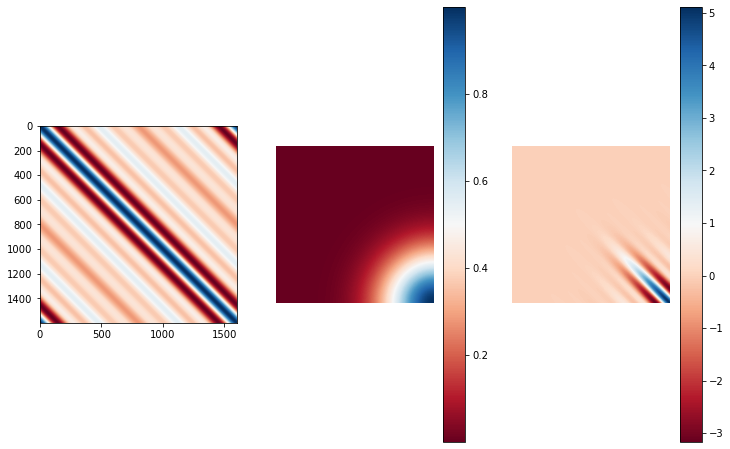

In [109]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(131)
plt.imshow(C_cos, cmap='RdBu')

ax = fig.add_subplot(132)
plt.imshow(C_exp, cmap='RdBu')
plt.axis('off')
plt.colorbar()

ax = fig.add_subplot(133)
plt.imshow(C, cmap='RdBu')
plt.axis('off')
plt.colorbar()

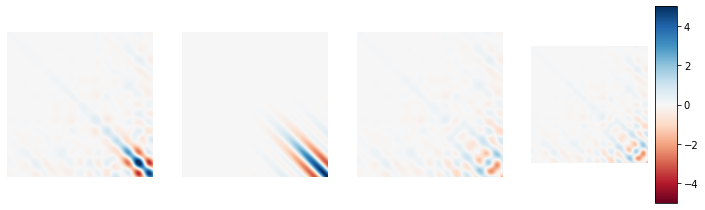

In [130]:
with open('results/haltere_rand_features/Pratt_STA.pickle', 'rb') as handle:
    STA_data = pickle.load(handle) 
C_data = STA_data.T @ STA_data
C_data *= N / np.trace(C_data) 

# C = haltere_covariance_matrix(1600, 2, 8, 50, scale=1)

fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(141)
plt.imshow(C_data, cmap='RdBu')
cmap_lim = 5
plt.clim(-cmap_lim, cmap_lim)
plt.axis('off')
# plt.colorbar()

ax = fig.add_subplot(142)
plt.imshow(C, cmap='RdBu')
plt.clim(-cmap_lim, cmap_lim)
plt.axis('off')
# plt.colorbar()

ax = fig.add_subplot(143)
plt.imshow(C_data - C, cmap='RdBu')
cmap_lim = 5
plt.clim(-cmap_lim, cmap_lim)
plt.axis('off')


ax = fig.add_subplot(144)
plt.imshow(C_data - C, cmap='RdBu')
cmap_lim = 5
plt.clim(-cmap_lim, cmap_lim)
plt.axis('off')
cbar = plt.colorbar(extend='neither', spacing='proportional',
                orientation='vertical', aspect=9)
plt.savefig('results/haltere_rand_features/covariance_matrices.pdf')

In [70]:
C_data.shape, C.shape

((1600, 1600), (150, 150))

## testing new covariance functions

In [ ]:
M, N, lowcut, highcut, decay_coef = 20, 100, 3, 8, 50
W = haltere_inspired_weights(M, N, lowcut, highcut, decay_coef, random_state=8)
t = np.linspace(0, 1, N)

fig = plt.figure(figsize=(6, 3))
# plt.plot(t, W[0], lw=5, c='k', alpha=0.5)
plt.plot(t, W[1], lw=5, c='k', alpha=1)
plt.tick_params(axis='both', which='both', left=False, bottom=False, labelleft=False, labelbottom=False)
plt.savefig('results/haltere_rand_features/decaying_haltere_weights.pdf')

## test on tasks

In [ ]:
import dask
from dask.distributed import Client
client = Client(threads_per_worker=5, n_workers=5)
client

In [ ]:
from data_fns import frequency_detection
from sklearn.model_selection import train_test_split
from estimator import RFClassifier, relu, parallelized_clf
from sklearn.svm import LinearSVC
import pickle
from sklearn.linear_model import SGDClassifier

# load data
n_samples, fs, signal_duration, k, a = 5000, 1500, 0.1, 5, 0.8
X, y = frequency_detection(n_samples, fs, k, signal_duration, a, random_state=20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
n_features = sorted(set(np.logspace(0, 3, 50).astype('int')))

# weight params
kwargs = {'lowcut': 2, 'highcut': 8, 'decay_coef': 50}
weights_halteres = {'weight_fun': haltere_inspired_weights, 'kwargs': kwargs}
weights_classical = {'weight_fun': classical_weights}

# params for classification
sgd = SGDClassifier(loss="squared_hinge", alpha=1, max_iter=200, tol=1e-5, shuffle=True, n_jobs=5,
                    learning_rate="optimal", early_stopping=True, validation_fraction=0.1, n_iter_no_change=20)
b = np.mean(la.norm(X_train)/ np.sqrt(X.shape[0]))

In [ ]:
results = {}
l = np.zeros_like(n_features, dtype='float')
results['classical'] = {'avg_test_err': l.copy(), 'std_test_err': l.copy()}
results['halteres'] = {'avg_test_err': l.copy(), 'std_test_err': l.copy()}
for i, n in enumerate(n_features):

    # classical random features
    params_classical = {'width': n, **weights_classical, 'bias': b, 'nonlinearity': relu, 'clf': sgd}
    _, _, results['classical']['avg_test_err'][i], results['classical']['std_test_err'][i] = parallelized_clf(RFClassifier, 
                                                                                                   params_classical, 
                                                                                                   X_train, y_train, 
                                                                                                   X_test, y_test, 
                                                                                                   n_iters=5)
    
    # haltere inspired
    params_halteres = {'width': n, **weights_halteres, 'bias': b, 'nonlinearity': relu, 'clf': sgd} 
    _, _, results['halteres']['avg_test_err'][i], results['halteres']['std_test_err'][i] = parallelized_clf(RFClassifier, 
                                                                                                            params_halteres, 
                                                                                                            X_train, y_train, 
                                                                                                            X_test, y_test, 
                                                                                                            n_iters=5)

    print('Iter: %d/%d' % (i, len(n_features)))
with open('results/freq_detection/freq_clf_decaying_weights.pickle', 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL) 



In [ ]:
with open('results/freq_detection/freq_clf_decaying_weights.pickle', 'rb') as handle:
    results = pickle.load(handle) 
    
fig = plt.figure(figsize=(10.6, 8))
ax = fig.add_subplot(111)
ax.errorbar(n_features, results['halteres']['avg_test_err'], yerr=results['halteres']['std_test_err'], 
            fmt='-', label='haltere-inspired',  markersize=4, lw=5, elinewidth=3)
ax.errorbar(n_features, results['classical']['avg_test_err'], yerr=results['classical']['std_test_err'], 
            fmt='-', label='classical', markersize=4, lw=5, elinewidth=3)
ax.set_xlim([0, 255])
plt.yticks(np.arange(0, 0.6, 0.1))
# plt.ylim([0, 0.55])
# ax.set_yscale('log')
plt.xlabel('Hidden layer width', fontsize=40)
plt.ylabel('Classification error', fontsize=40)
plt.xticks(np.arange(0, 255, 50))
ax.tick_params(axis = 'both', which = 'major', labelsize = 40, width=2, length=6)
plt.legend(loc = 'upper right', fontsize=30)
plt.savefig('results/haltere_rand_features/freq_detection_decaying_weights.pdf')

## Frequency XOR

In [ ]:
from data_fns import frequency_XOR
from sklearn.model_selection import train_test_split
from estimator import RFClassifier, relu
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier

# load data
n_samples, fs, signal_duration, k1, k2, a = 5000, 1500, 0.1, 5, 8, 0.99
X, y = frequency_XOR(n_samples, fs, k1, k2, signal_duration, a, shuffle=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
n_features = sorted(set(np.logspace(0, 3, 50).astype('int')))

# weight params
kwargs = {'lowcut': 3, 'highcut': 13, 'decay_coef': 50}
weights_halteres = {'weight_fun': haltere_inspired_weights, 'kwargs': kwargs}
weights_classical = {'weight_fun': classical_weights}

# params for classification
sgd = SGDClassifier(loss="squared_hinge", alpha=1, max_iter=200, tol=1e-5, shuffle=True, n_jobs=5,
                    learning_rate="optimal", early_stopping=True, validation_fraction=0.1, n_iter_no_change=20)
b = np.mean(la.norm(X_train)/ np.sqrt(X.shape[0]))

In [ ]:
results = {}
l = np.zeros_like(n_features, dtype='float')
results['classical'] = {'avg_test_err': l.copy(), 'std_test_err': l.copy()}
results['halteres'] = {'avg_test_err': l.copy(), 'std_test_err': l.copy()}
for i, n in enumerate(n_features):

    # classical random features
    params_classical = {'width': n, **weights_classical, 'bias': b, 'nonlinearity': relu, 'clf': sgd}
    _, _, results['classical']['avg_test_err'][i], results['classical']['std_test_err'][i] = parallelized_clf(RFClassifier, 
                                                                                                   params_classical, 
                                                                                                   X_train, y_train, 
                                                                                                   X_test, y_test, 
                                                                                                   n_iters=5)
    
    # haltere inspired
    params_halteres = {'width': n, **weights_halteres, 'bias': b, 'nonlinearity': relu, 'clf': sgd} 
    _, _, results['halteres']['avg_test_err'][i], results['halteres']['std_test_err'][i] = parallelized_clf(RFClassifier, 
                                                                                                            params_halteres, 
                                                                                                            X_train, y_train, 
                                                                                                            X_test, y_test, 
                                                                                                            n_iters=5)

    print('Iter: %d/%d' % (i, len(n_features)))
with open('results/freq_XOR/freq_XOR_decaying_weights.pickle', 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL) 

In [ ]:
with open('results/freq_XOR/freq_XOR_decaying_weights.pickle', 'rb') as handle:
    results = pickle.load(handle)

fig = plt.figure(figsize=(10.6, 8))
ax = fig.add_subplot(111)
ax.errorbar(n_features, results['halteres']['avg_test_err'], yerr=results['halteres']['std_test_err'], 
            fmt='-', label='haltere-inspired',  markersize=4, lw=5, elinewidth=3)
ax.errorbar(n_features, results['classical']['avg_test_err'], yerr=results['classical']['std_test_err'], 
            fmt='-', label='classical', markersize=4, lw=5, elinewidth=3)
ax.set_xlim([0, 255])
plt.yticks(np.arange(0, 0.6, 0.1))
# plt.ylim([0, 0.55])
# ax.set_yscale('log')
plt.xlabel('Hidden layer width', fontsize=40)
plt.ylabel('Classification error', fontsize=40)
plt.xticks(np.arange(0, 255, 50))
ax.tick_params(axis = 'both', which = 'major', labelsize = 40, width=2, length=6)
plt.legend(loc = 'upper right', fontsize=30)
plt.savefig('results/haltere_rand_features/freq_XOR_decaying_weights.pdf')